# Compute syllable similarities

In [1]:
import joblib
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from pathlib import Path
from tqdm.auto import tqdm
from toolz import valmap, compose, curry
from collections import defaultdict
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, complete, ward, leaves_list
from tslearn.barycenters import softdtw_barycenter
from tslearn.utils import to_time_series_dataset
from aging.moseq_modeling.pca import apply_whitening, get_whitening_params_from_training_data
from aging.plotting import format_plots, figure, save_factory, PLOT_CONFIG, COLORMAPS

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig-s2", tight_layout=False)

In [3]:
mu, L = get_whitening_params_from_training_data(Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11'))

In [4]:
def compute_center():
    center_x = (pl.col("centroid_x_mm").max() - pl.col("centroid_x_mm").min()) / 2
    center_y = (pl.col("centroid_y_mm").max() - pl.col("centroid_y_mm").min()) / 2

    return center_x.over(["age", "uuid"]).alias("center_x"), center_y.over(["age", "uuid"]).alias("center_y")


def compute_dist_to_center():
    distance_x = pl.col("centroid_x_mm") - pl.col("center_x")
    distance_y = pl.col("centroid_y_mm") - pl.col("center_y")
    return (distance_x.pow(2) + distance_y.pow(2)).sqrt().mean().alias("center_distance")

In [5]:
to_mtx = compose(np.array, list, dict.values)


def load_male_ontogeny():
    df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_syllable_df_v00.parquet')
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

    # compute durations
    idx = np.where(df['onsets'])[0]
    durs = np.diff(idx).tolist() + [len(df) - idx[0]]
    df.loc[df.index[idx], 'dur'] = durs
    df['dur'] = df['dur'].ffill().astype('int16')

    usage_df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet",
        columns=list(map(str, keep_syllables)),
    ).query('age < 106')

    pc_keys = [f"pc_{i:02d}" for i in range(10)]
    df[pc_keys] = df[pc_keys].interpolate()

    # filter short duration syllables
    df = df.query('dur > 6 & dur < 21')  # frames

    # filter for only syllables we are keeping in the paper
    df = df[df['syllables'].isin(keep_syllables)]

    syll_counts = df.query("onsets").groupby("age")["syllables"].value_counts()
    # only include age/syllable pairs that have more than 50 examples
    syll_data = syll_counts[syll_counts > 50]

    return df, usage_df, syll_data


# sample a subset of syllables across ages
def sample_syllable(df, syllable, ages, n_samples_per_age=6, length=20):
    df = df.query("syllables == @syllable")
    df = df[df["age"].isin(ages)].copy()
    df["unique_id"] = df["onsets"].cumsum()
    sample = []
    for _age, _df in df.groupby("age", sort=False):
        idx = np.random.permutation(_df["unique_id"].unique())[:n_samples_per_age]
        sample.append(_df[_df["unique_id"].isin(idx)])
    sample = pd.concat(sample)

    # repeat sampling until I get what I want
    while sample['dur'].max() < length:
        sample = []
        for _age, _df in df.groupby("age", sort=False):
            idx = np.random.permutation(_df["unique_id"].unique())[:n_samples_per_age]
            sample.append(_df[_df["unique_id"].isin(idx)])
        sample = pd.concat(sample)

    return sample


def construct_ts(df):
    out = []
    pc_keys = [f"pc_{i:02d}" for i in range(10)]
    for _, _df in df.groupby('unique_id', sort=False):
        out.append(apply_whitening(_df[pc_keys].to_numpy(), L, mu))
    return to_time_series_dataset(out)


def compute_syllable_distances(df, keep_syllables, syll_data, seed=0, gamma=1.5, n_samples_per_age=16, length=24):
    np.random.seed(seed)

    if not isinstance(gamma, (tuple, list)):
        gamma = [gamma]

    syllable_traj = defaultdict(dict)
    for syllable in tqdm(keep_syllables):
        has_ages = syll_data.loc[pd.IndexSlice[:, syllable]].index
        sample = sample_syllable(df, syllable, has_ages, n_samples_per_age=n_samples_per_age, length=length)
        ts = construct_ts(sample)
        for g in gamma:
            bc = softdtw_barycenter(ts, gamma=g, max_iter=2_000)
            syllable_traj[g][syllable] = bc

    flatten = curry(valmap)(np.ndarray.flatten)
    flattened = valmap(flatten, syllable_traj)

    mtx = valmap(to_mtx, flattened)
    dists = {m: valmap(lambda tx: pdist(tx, metric=m), mtx) for m in ('correlation', 'euclidean', 'cosine')}
    return dists

In [6]:
df, usage_df, syll_data = load_male_ontogeny()
keep_syllables = usage_df.columns

In [7]:
pl_df = pl.scan_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_syllable_df_v00.parquet')
male_center_dist = pl_df.with_columns(*compute_center()).group_by(['age', 'uuid', "syllables"]).agg(compute_dist_to_center()).collect().to_pandas()

In [8]:
dists = compute_syllable_distances(
    df,
    keep_syllables,
    syll_data,
    seed=0,
    gamma=[1.5, 4],
    n_samples_per_age=25,
    length=20,
)

  0%|          | 0/58 [00:00<?, ?it/s]

In [9]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
female_usage_df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet",
    columns=list(map(str, keep_syllables)),
).query('age < 106')

In [10]:
pl_df = pl.scan_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_syllable_df_v00.parquet')
female_center_dist = pl_df.with_columns(*compute_center()).group_by(['age', 'uuid', "syllables"]).agg(compute_dist_to_center()).collect().to_pandas()

In [11]:
age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

female_usage_df = female_usage_df.reset_index(level='age')

female_usage_df['age'] = female_usage_df['age'].map(age_mapping).fillna(female_usage_df['age'])
# Set the index back
female_usage_df.set_index('age', inplace=True, append=True)

In [12]:
female_center_dist['age'] = female_center_dist['age'].map(age_mapping).fillna(female_center_dist['age'])

In [13]:
class_df = pd.read_csv(
    "../v11_syllable_labels_v3.csv", index_col="Original ID", usecols=range(4)
)

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


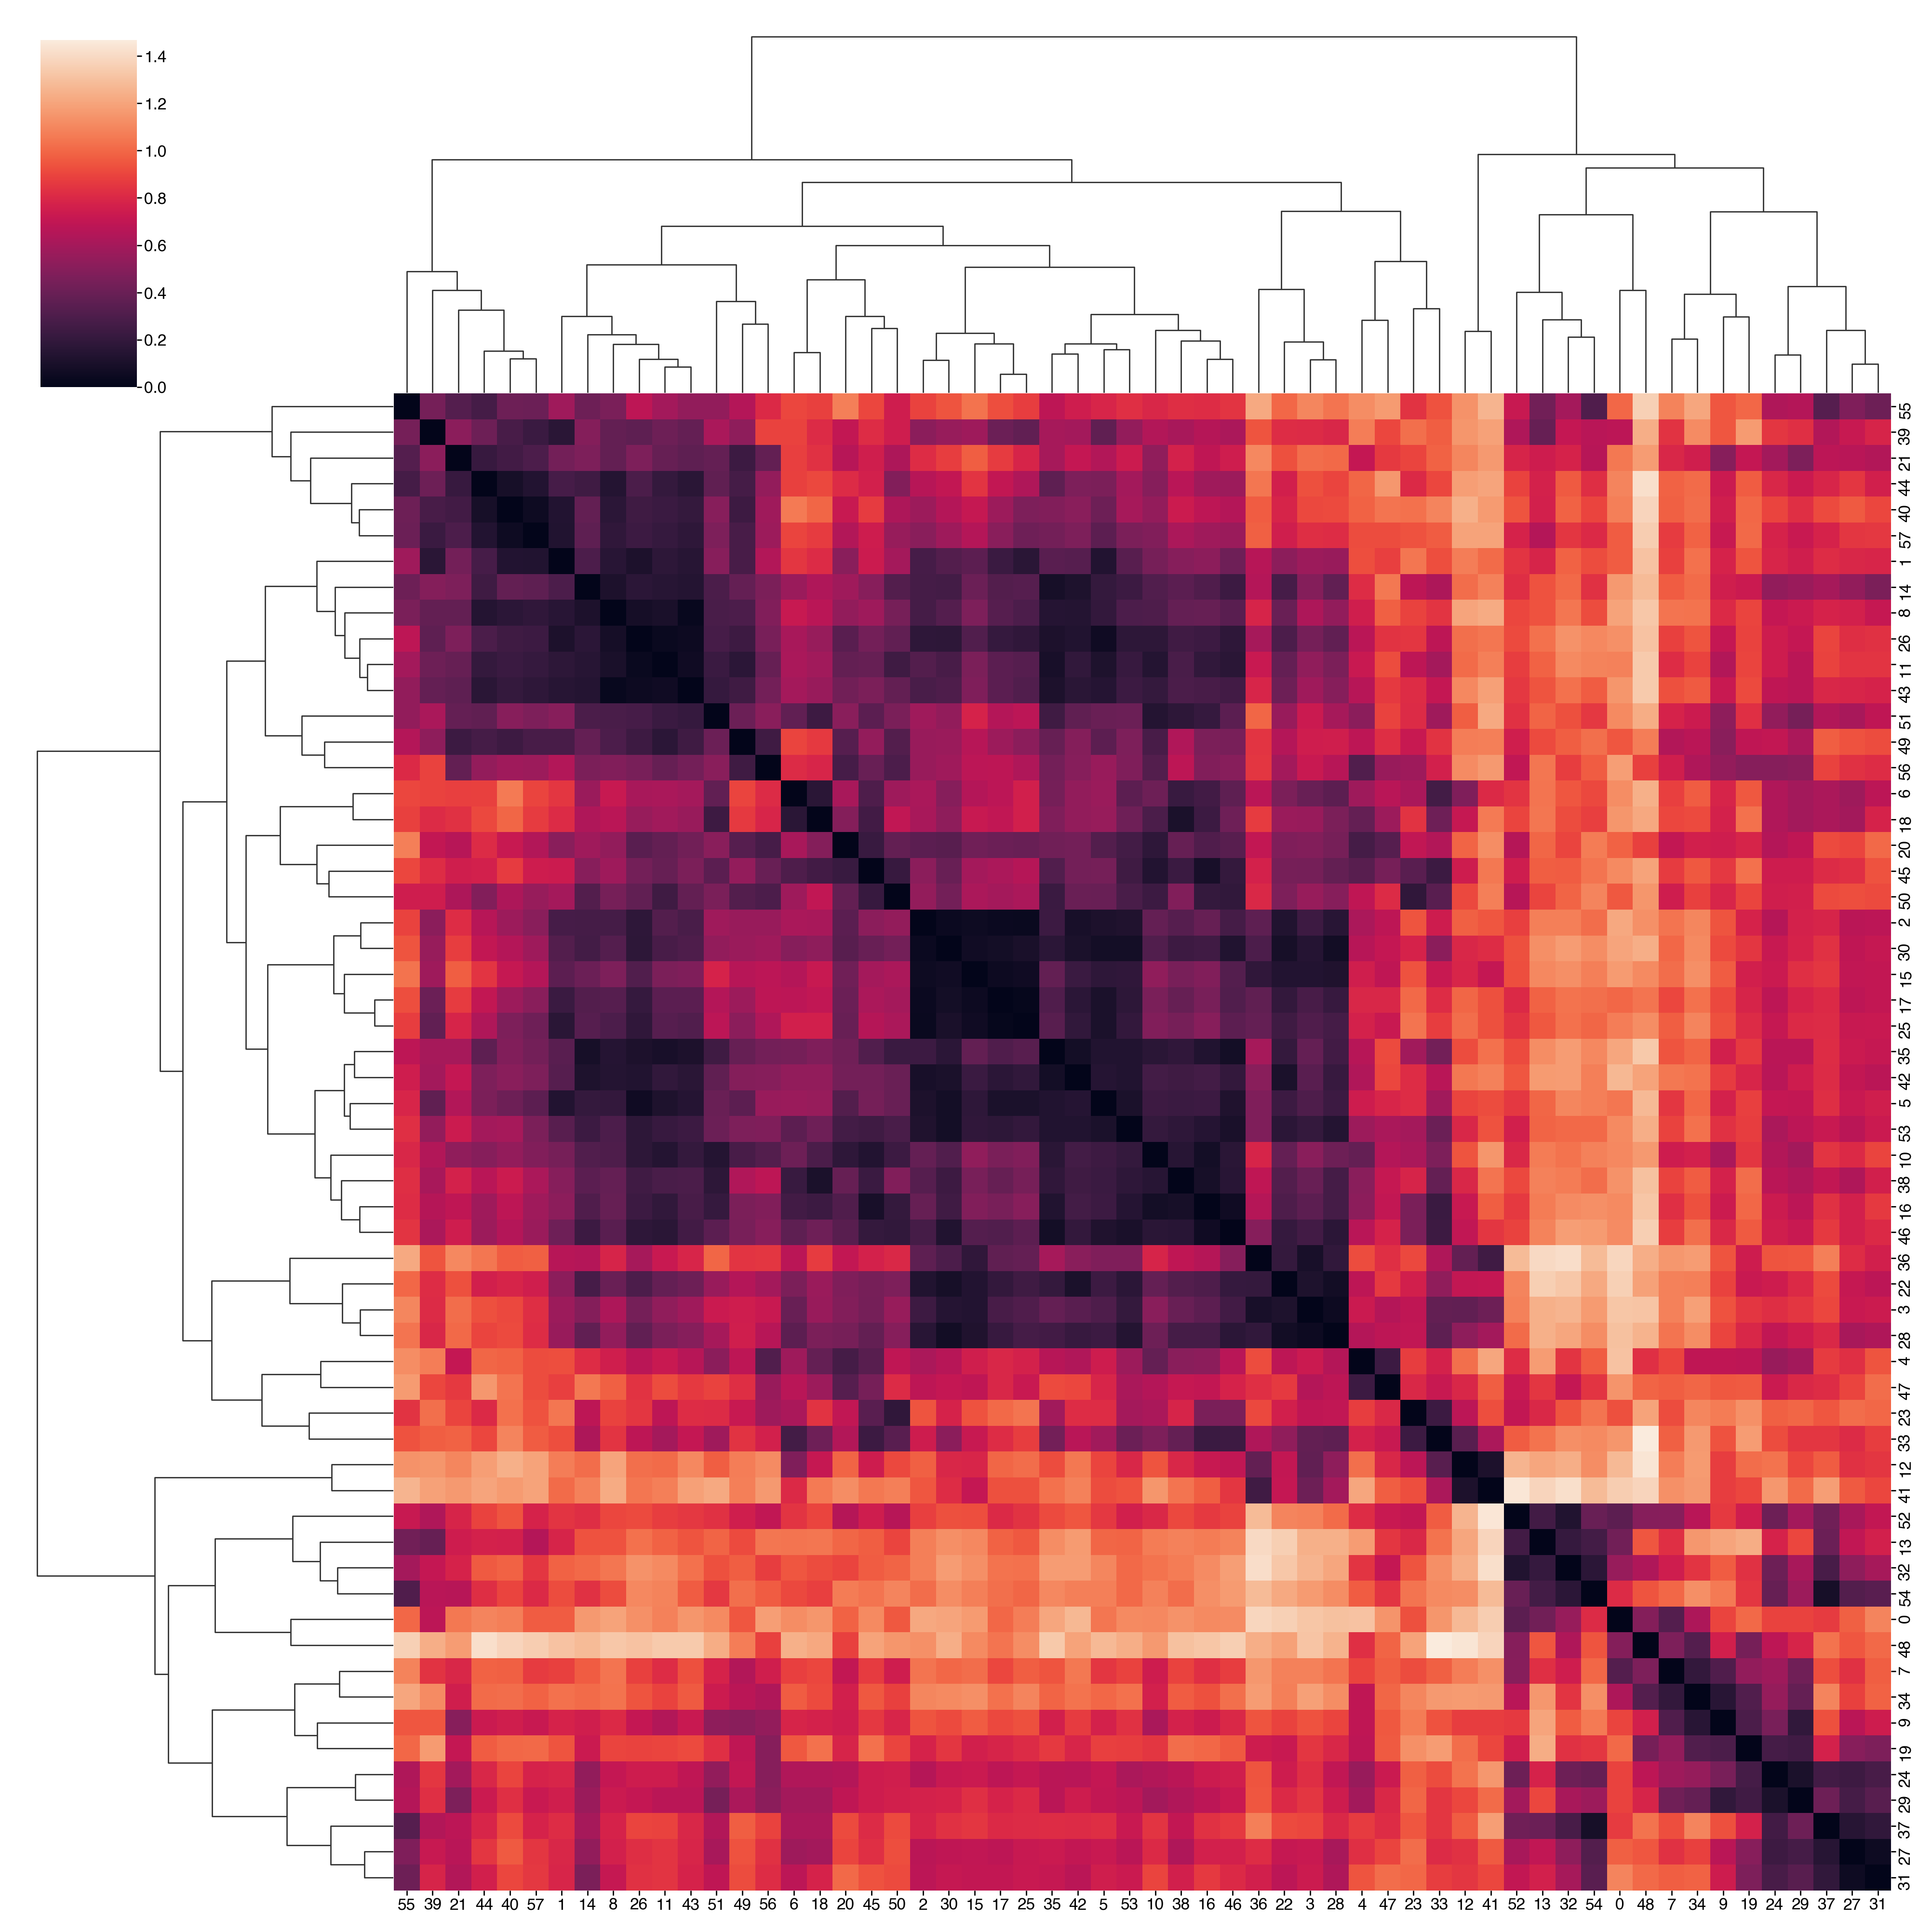

In [14]:
sns.clustermap(squareform(dists['correlation'][4]), method='complete')

In [6]:
def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

In [7]:
bambi_df = pd.concat([
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-29-ontogeny_males_raw_usage_df_beh_age.parquet').assign(sex=0),
    pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-29-ontogeny_females_raw_usage_df_beh_age.parquet').assign(sex=1),
]).set_index('sex', append=True)

In [18]:
raw_df = pd.concat([
    usage_df.assign(sex=0),
    female_usage_df.assign(sex=1).reorder_levels(usage_df.index.names),
]).set_index('sex', append=True)

In [8]:
bambi_avgs = bambi_df.groupby(['sex', 'age']).mean().rolling(3, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)

<Axes: xlabel='age'>

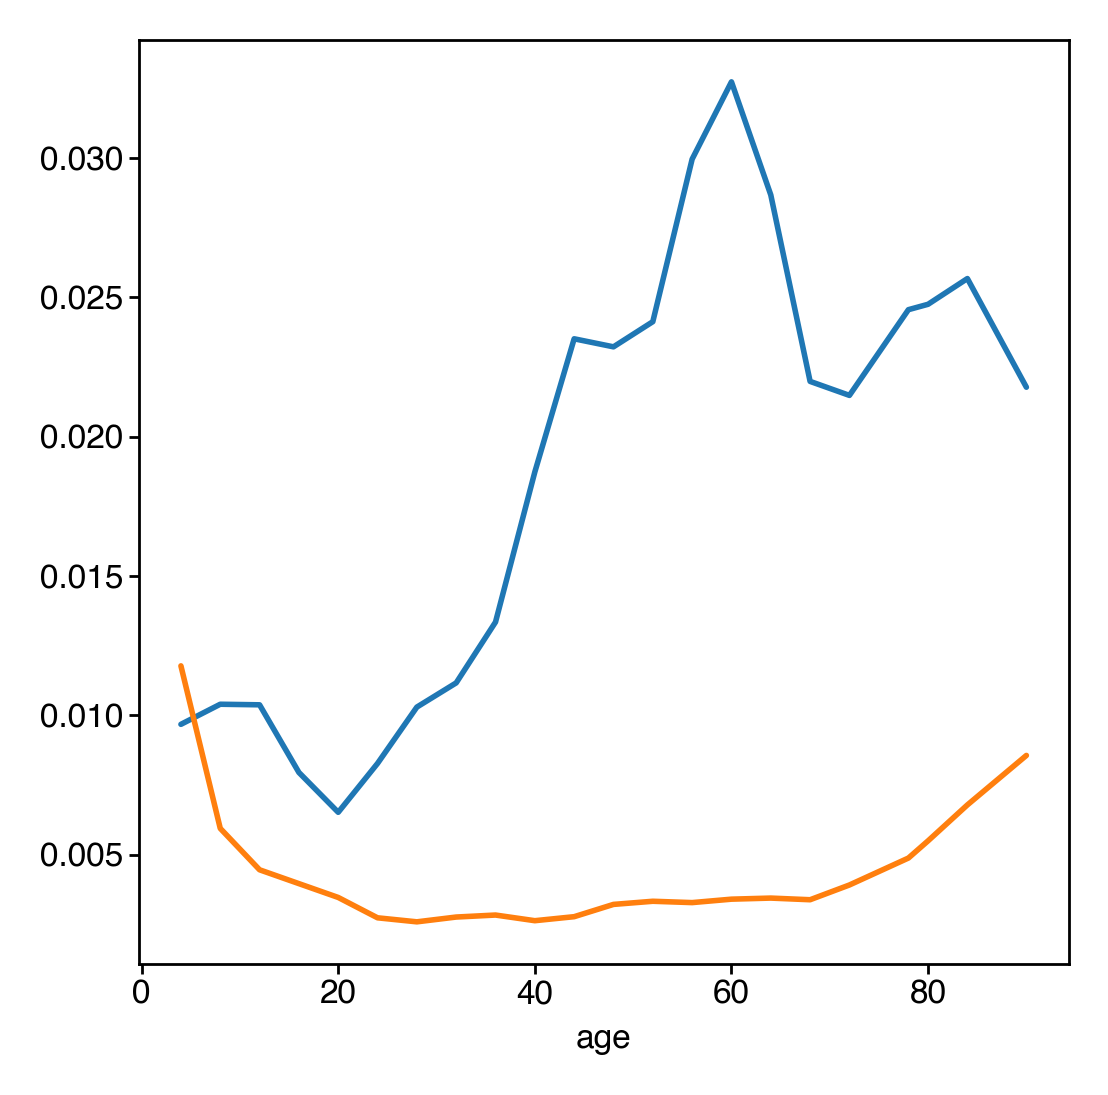

In [11]:
bambi_avgs.loc[0][59].plot(label='male')
bambi_avgs.loc[1][59].plot(label='female')

In [ ]:
raw_avgs = raw_df.groupby(['sex', 'age']).mean().rolling(3, center=True, min_periods=1, win_type='exponential').mean(tau=1.5)
raw_mm_avgs = raw_df.groupby(['sex', 'age']).mean().rolling(3, center=True, min_periods=1, win_type='exponential').mean(tau=1.5).groupby('sex').transform(minmax)

In [20]:
female_kmeans = joblib.load('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-kmeans-label-dict-beh-age.p')
male_kmeans = joblib.load('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-kmeans-label-dict-beh-age.p')

# female_nmf = joblib.load('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/female-nmf-components.p')
# male_nmf = joblib.load('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/male-nmf-components.p')

In [21]:
female_kmeans_r = {}
for k, v in female_kmeans.items():
    for syll in v:
        female_kmeans_r[syll] = k

male_kmeans_r = {}
for k, v in male_kmeans.items():
    for syll in v:
        male_kmeans_r[syll] = k

In [22]:
male_kmeans_colors = cc.glasbey_cool[15:15 + len(male_kmeans)]
female_kmeans_colors = cc.glasbey_warm[11:11 + len(female_kmeans)]

# male_nmf_colors = cc.glasbey_cool[15:19]
# female_nmf_colors = cc.glasbey_warm[11:15]

In [23]:
unique_classes = class_df['Class'].unique()

class_color_map = dict(map(reversed, enumerate(unique_classes)))
class_color_map = valmap(lambda x: cc.glasbey[x], class_color_map)

webf NOT subset; don't know how to subset; dropped


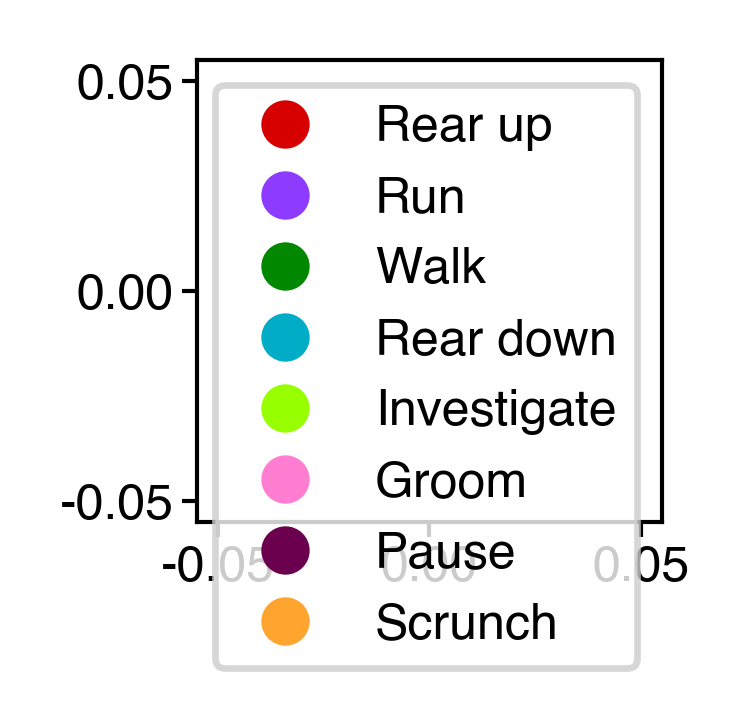

In [24]:
fig = figure(1, 1)
for k, v in class_color_map.items():
    plt.plot([], [], 'o', color=v, label=k)
plt.legend()
saver(fig, 'class-legend');

webf NOT subset; don't know how to subset; dropped


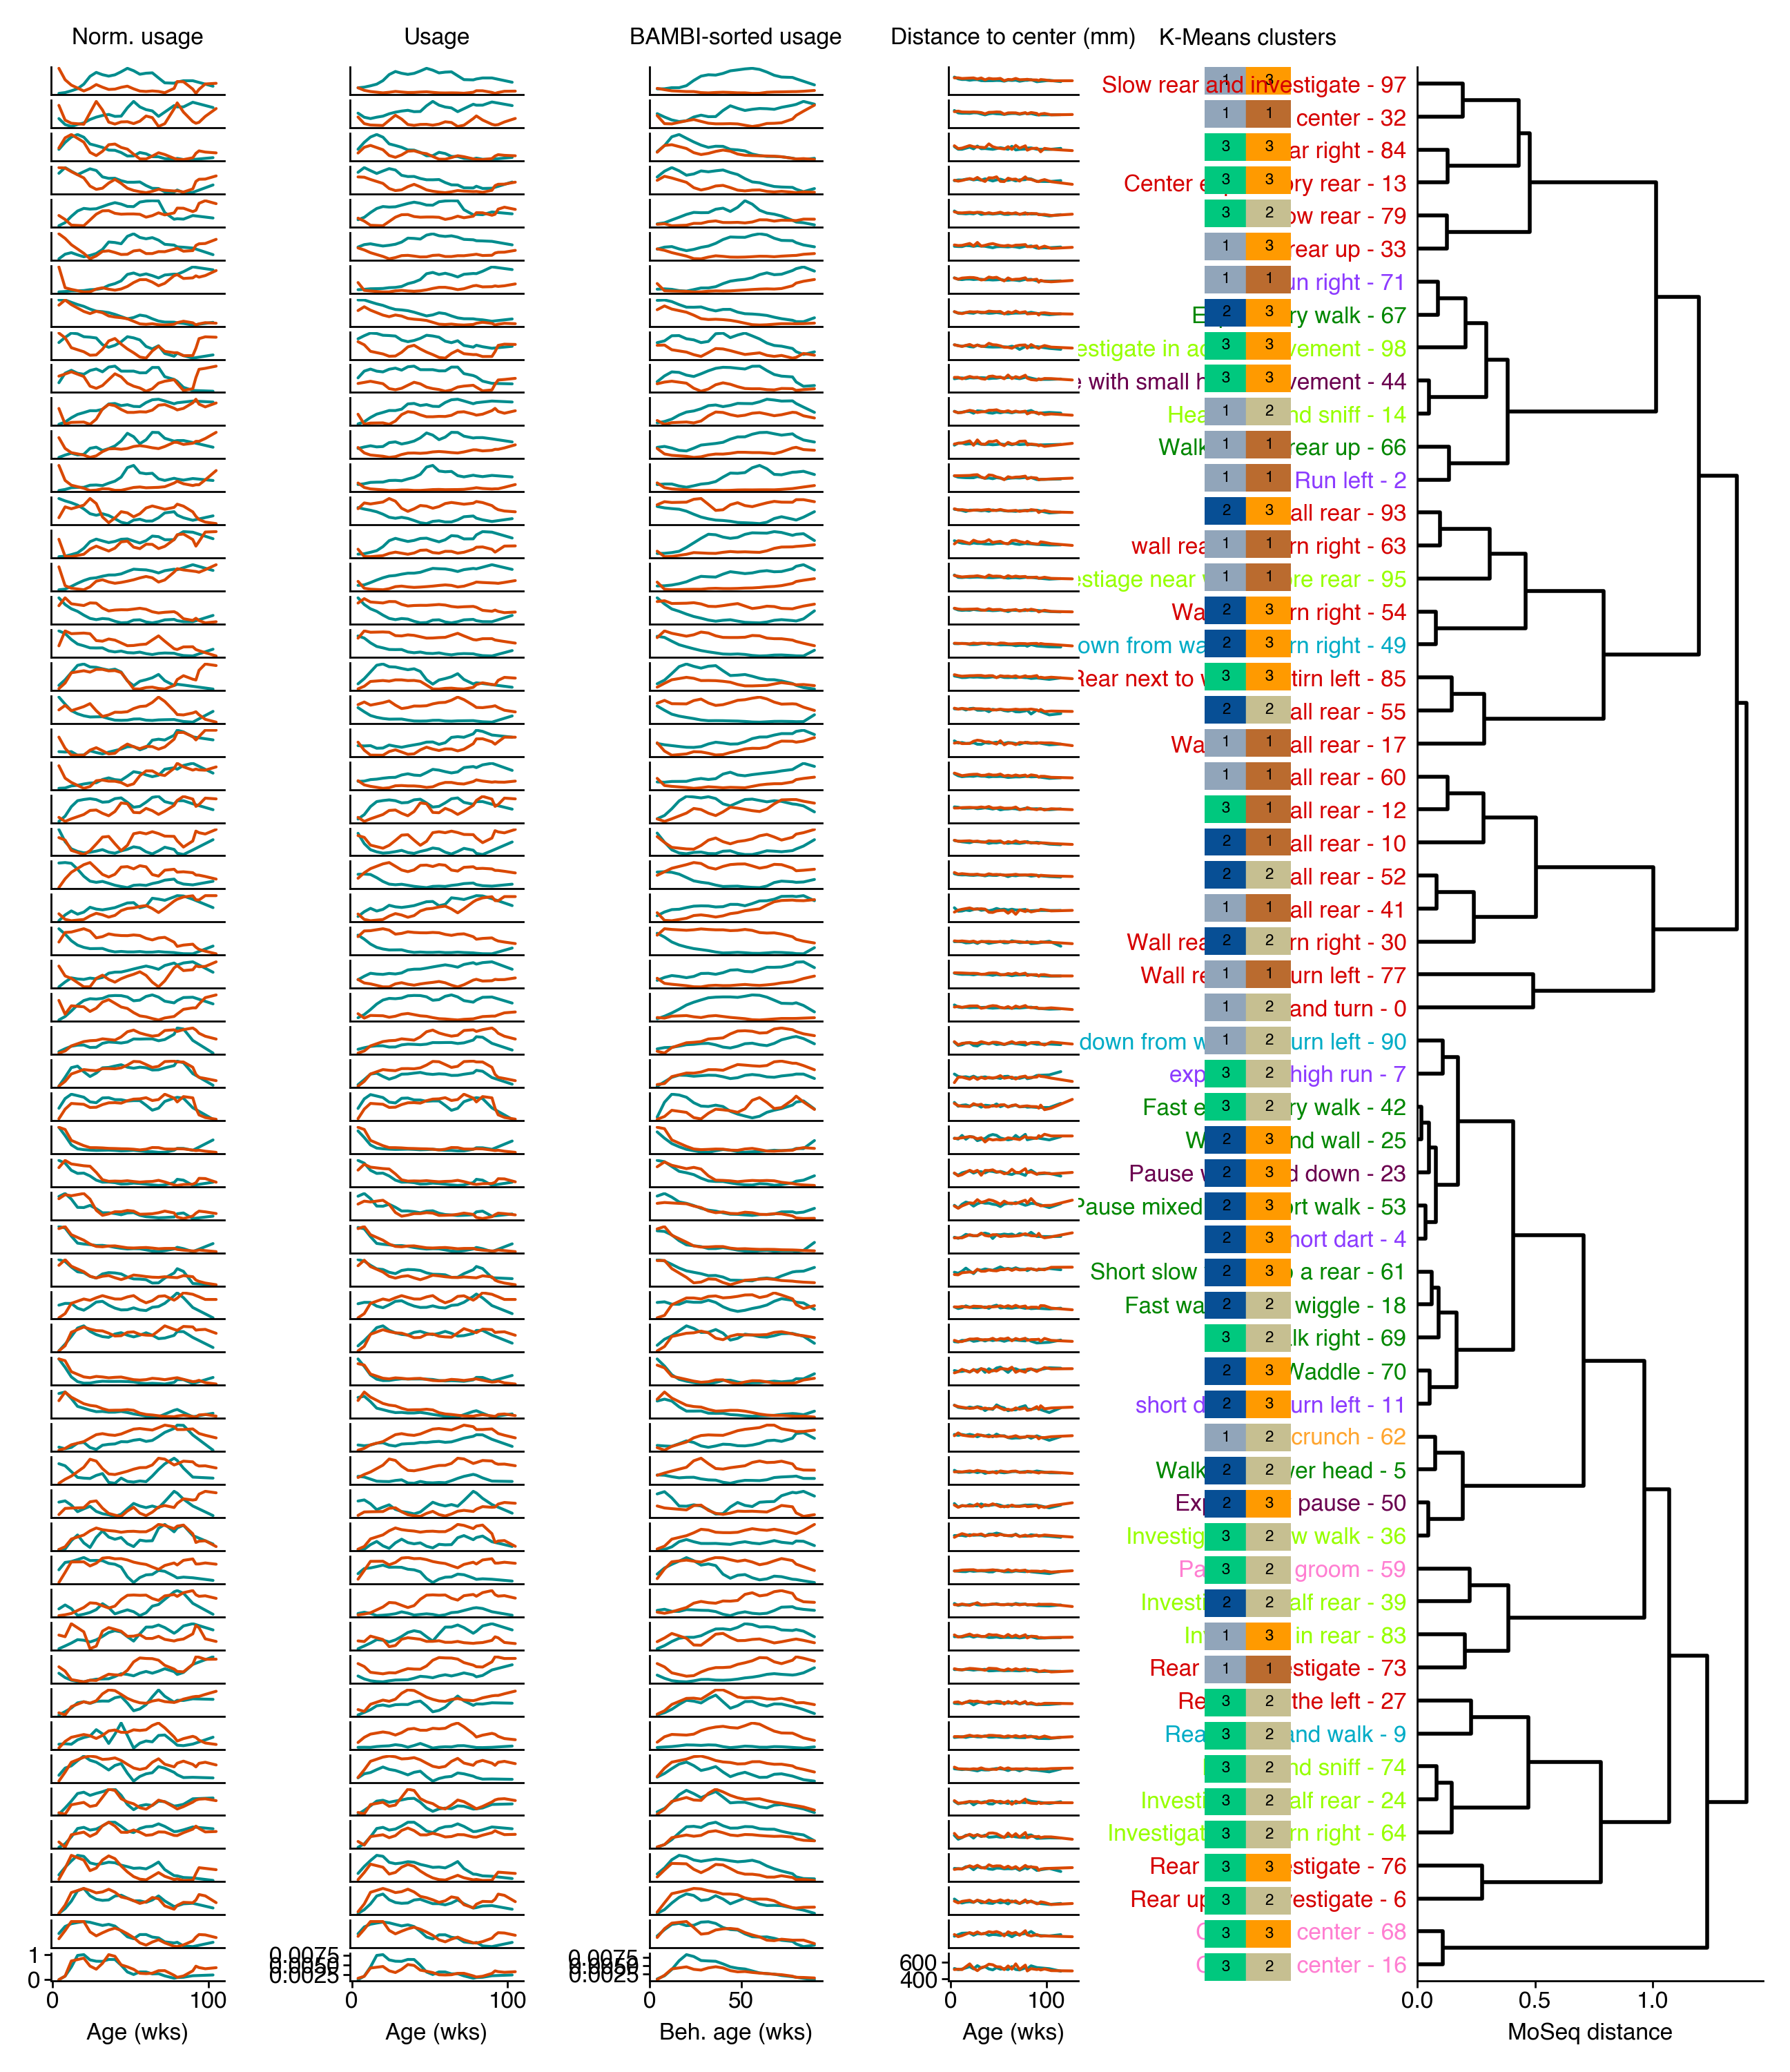

In [25]:
Z = complete(dists['cosine'][1.5])

leaves = leaves_list(Z)
# mosaic = [[f"{l}_mm", str(l), f"{l}_bambi", f"{l}_kmeans", f"{l}_nmf", "D"] for l in leaves]

# NOTE: removed nmf
mosaic = [[f"{l}_mm", str(l), f"{l}_bambi", f"{l}_dtc", f"{l}_kmeans", "D"] for l in leaves]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 9), width_ratios=[1, 1, 1, 0.75, 0.5, 2], gridspec_kw=dict(wspace=0.7))

dendrogram(Z, orientation='right', above_threshold_color='k', color_threshold=0, ax=ax['D'])
ticks = ax['D'].get_yticklabels()
tick_sylls = [int(t.get_text()) for t in ticks]
new_ticks = [f"{class_df.loc[keep_syllables[t], 'Short description']} - {keep_syllables[t]}" for t in tick_sylls]
ax['D'].set_yticklabels(new_ticks)
ticks = ax['D'].get_yticklabels()
for t, s in zip(ticks, tick_sylls):
    _class = class_df.loc[keep_syllables[s], "Class"]
    t.set_color(class_color_map[_class])

max_dtc = max(male_center_dist.groupby(['age', 'syllables'])['center_distance'].mean().max(), female_center_dist.groupby(['age', 'syllables'])['center_distance'].mean().max())
min_dtc = min(male_center_dist.groupby(['age', 'syllables'])['center_distance'].mean().min(), female_center_dist.groupby(['age', 'syllables'])['center_distance'].mean().min())

for i, l in enumerate(leaves):

    curr_syll = keep_syllables[l]

    # "raw" syllable use
    _male_df = raw_avgs.loc[0]
    _female_df = raw_avgs.loc[1]
    a = ax[str(l)]
    a.plot(_male_df.index, _male_df[curr_syll], color=COLORMAPS.ont_male(255), lw=0.75)
    a.plot(_female_df.index, _female_df[curr_syll], color=COLORMAPS.ont_female(255), lw=0.75)

    if i < len(leaves) - 1:
        a.set(yticks=[], xticks=[])
    else:
        # a.set(yticks=[])
        a.set(xlabel="Age (wks)")
    if i == 0:
        a.set(title="Usage")

    # min-max normalized syllable use
    a = ax[f"{l}_mm"]
    _male_df = raw_mm_avgs.loc[0]
    _female_df = raw_mm_avgs.loc[1]
    a.plot(_male_df.index, _male_df[curr_syll], color=COLORMAPS.ont_male(255), lw=0.75)
    a.plot(_female_df.index, _female_df[curr_syll], color=COLORMAPS.ont_female(255), lw=0.75)

    if i < len(leaves) - 1:
        a.set(yticks=[], xticks=[])
    else:
        # a.set(yticks=[])
        a.set(xlabel="Age (wks)")
    if i == 0:
        a.set(title="Norm. usage")

    # bambi sorted "raw" syllable use
    a = ax[f"{l}_bambi"]

    _male_df = bambi_avgs.loc[0]
    _female_df = bambi_avgs.loc[1]
    a.plot(_male_df.index, _male_df[curr_syll], color=COLORMAPS.ont_male(255), lw=0.75)
    a.plot(_female_df.index, _female_df[curr_syll], color=COLORMAPS.ont_female(255), lw=0.75)

    if i < len(leaves) - 1:
        a.set(yticks=[], xticks=[])
    else:
        # a.set(yticks=[])
        a.set(xlabel="Beh. age (wks)")
    if i == 0:
        a.set(title="BAMBI-sorted usage")

    # distance to center
    a = ax[f"{l}_dtc"]
    sns.lineplot(data=male_center_dist.query("syllables == @curr_syll"), x="age", y="center_distance", errorbar=None, color=COLORMAPS.ont_male(255), lw=0.75, ax=a)
    sns.lineplot(data=female_center_dist.query("syllables == @curr_syll"), x="age", y="center_distance", errorbar=None, color=COLORMAPS.ont_female(255), lw=0.75, ax=a)
    a.set(ylim=(min_dtc, max_dtc), ylabel="", xlabel="")

    if i < len(leaves) - 1:
        a.set(yticks=[], xticks=[])
    else:
        # a.set(yticks=[])
        a.set(xlabel="Age (wks)")
    if i == 0:
        a.set(title="Distance to center (mm)")

    # k-means
    a = ax[f"{l}_kmeans"]
    rect = plt.Rectangle((0, 0), 0.5, 1, color=male_kmeans_colors[male_kmeans_r[keep_syllables[l]]])
    a.add_patch(rect)
    a.text(0.25, 0.5, str(male_kmeans_r[keep_syllables[l]] + 1), fontdict=dict(fontsize=4), ha='center', va='center')
    rect = plt.Rectangle((0.5, 0), 0.5, 1, color=female_kmeans_colors[female_kmeans_r[keep_syllables[l]]])
    a.add_patch(rect)
    a.text(0.75, 0.5, str(female_kmeans_r[keep_syllables[l]] + 1), fontdict=dict(fontsize=4), ha='center', va='center')
    a.set(xlim=(0, 1), ylim=(0, 1))
    if i == 0:
        a.set(title="K-Means clusters")
    a.axis('off')

    # NOTE: removed NMF
    # nmf
    # a = ax[f"{l}_nmf"]
    # a.bar(range(4), male_nmf[:, l], color=male_nmf_colors, ec='none', width=0.95)
    # a.bar(range(4, 8), female_nmf[:, l], color=female_nmf_colors, ec='none', width=0.95)
    # # a.set(ylim=(0, 2.5))
    # if i < len(leaves) - 1:
    #     a.set(yticks=[], xticks=[])
    # else:
    #     a.set(yticks=[], xticks=[0, 3, 4, 7], xticklabels=[1, 4, 1, 4], xlabel="Component")
    # if i == 0:
    #     a.set(title="NMF coefficients")
ax['D'].set(xlabel='MoSeq distance')
sns.despine()
saver(fig, "behavior-similarity-dendrogram");